In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from xgboost import XGBClassifier, plot_tree, to_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss
)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from bayes_opt import BayesianOptimization


In [2]:
df = pd.read_csv('clean_df (1).csv')
df

,MS SubClass,Lot Frontage,Lot Area,HouseStyle_MedianPrice,BldgType_MedianPrice,Neighborhood_MedianPrice,Combo_PriceMean,Overall Qual,Overall Cond,Year Built,...,Exterior2nd_Simp_Wd Sdng,Exterior2nd_Simp_Wd Shng,Functional_Encoded,SaleType_Best,SaleType_Good,SaleType_Average,SaleType_Low,SaleCond_High,SaleCond_Typical,SaleCond_Low
0,20,141.0,31770,155000.0,165000.0,140000.0,140000.0,6,5,1960,...,False,False,4,0,1,0,0,0,1,0
1,20,80.0,11622,155000.0,165000.0,140000.0,140000.0,5,6,1961,...,False,False,4,0,1,0,0,0,1,0
2,20,81.0,14267,155000.0,165000.0,140000.0,140000.0,6,6,1958,...,True,False,4,0,1,0,0,0,1,0
3,20,93.0,11160,155000.0,165000.0,140000.0,140000.0,7,5,1968,...,False,False,4,0,1,0,0,0,1,0
4,60,74.0,13830,189000.0,165000.0,183000.0,185000.0,5,5,1997,...,False,False,4,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,37.0,7937,165000.0,165000.0,153500.0,158950.0,6,6,1984,...,False,False,4,0,1,0,0,0,1,0
2923,20,74.0,8885,155000.0,165000.0,153500.0,140000.0,5,5,1983,...,False,False,4,0,1,0,0,0,1,0
2924,85,62.0,10441,143000.0,165000.0,153500.0,153500.0,5,5,1992,...,False,True,4,0,1,0,0,0,1,0
2925,20,77.0,10010,155000.0,165000.0,153500.0,140000.0,5,5,1974,...,False,False,4,0,1,0,0,0,1,0


In [3]:
df['SalePrice_binned'] = pd.qcut(df['SalePrice'], q=5, labels=False)

In [4]:
df['SalePrice_binned'].value_counts()

,count
SalePrice_binned,
0,595
3,593
2,581
1,580
4,578


=> given the built in pd.qcut method, we discretisized the continuous target variable "SalePrice" into 4 classes

The qcut method uses a quantile based approach to discretize a continuous variable

Now, implementing xgboost for a Multi-Class classification, using SalePrice_binned as target variable

In [5]:
df

,MS SubClass,Lot Frontage,Lot Area,HouseStyle_MedianPrice,BldgType_MedianPrice,Neighborhood_MedianPrice,Combo_PriceMean,Overall Qual,Overall Cond,Year Built,...,Exterior2nd_Simp_Wd Shng,Functional_Encoded,SaleType_Best,SaleType_Good,SaleType_Average,SaleType_Low,SaleCond_High,SaleCond_Typical,SaleCond_Low,SalePrice_binned
0,20,141.0,31770,155000.0,165000.0,140000.0,140000.0,6,5,1960,...,False,4,0,1,0,0,0,1,0,3
1,20,80.0,11622,155000.0,165000.0,140000.0,140000.0,5,6,1961,...,False,4,0,1,0,0,0,1,0,0
2,20,81.0,14267,155000.0,165000.0,140000.0,140000.0,6,6,1958,...,False,4,0,1,0,0,0,1,0,2
3,20,93.0,11160,155000.0,165000.0,140000.0,140000.0,7,5,1968,...,False,4,0,1,0,0,0,1,0,4
4,60,74.0,13830,189000.0,165000.0,183000.0,185000.0,5,5,1997,...,False,4,0,1,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,37.0,7937,165000.0,165000.0,153500.0,158950.0,6,6,1984,...,False,4,0,1,0,0,0,1,0,1
2923,20,74.0,8885,155000.0,165000.0,153500.0,140000.0,5,5,1983,...,False,4,0,1,0,0,0,1,0,1
2924,85,62.0,10441,143000.0,165000.0,153500.0,153500.0,5,5,1992,...,True,4,0,1,0,0,0,1,0,1
2925,20,77.0,10010,155000.0,165000.0,153500.0,140000.0,5,5,1974,...,False,4,0,1,0,0,0,1,0,2


In [6]:
X = df.drop(columns=['SalePrice', 'SalePrice_binned'])
y = df['SalePrice_binned']

Firstly, implemented without stratification

In [7]:
'''80 test 20 train'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
xgb80_20 = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='multi:softmax', num_class=5)


In [9]:
xgb80_20.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=5, ...)

In [10]:
y_pred_80_20 = xgb80_20.predict(X_test)
y_pred_proba_80_20 = xgb80_20.predict_proba(X_test)
y_pred_80_20
y_pred_proba_80_20

array([[0.00668172, 0.00736774, 0.01377393, 0.05817899, 0.9139976 ],
       [0.28747633, 0.48347142, 0.17101167, 0.0320384 , 0.02600219],
       [0.02339986, 0.02651033, 0.36632574, 0.55858946, 0.02517465],
       ...,
       [0.00569842, 0.00628348, 0.00795654, 0.02305246, 0.95700914],
       [0.03600165, 0.04078722, 0.18277706, 0.59247   , 0.14796408],
       [0.18227063, 0.63760614, 0.11206552, 0.03376586, 0.0342919 ]],
      dtype=float32)

In [11]:
# accuracy
acc = accuracy_score(y_test, y_pred_80_20)
print(f"Accuracy: {acc:.4f}")

#  Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_80_20))

# 3. Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_80_20))


Accuracy: 0.6962

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       120
           1       0.58      0.61      0.59       121
           2       0.55      0.47      0.51       114
           3       0.68      0.73      0.71       120
           4       0.90      0.86      0.88       111

    accuracy                           0.70       586
   macro avg       0.70      0.70      0.70       586
weighted avg       0.69      0.70      0.69       586


Confusion Matrix:
 [[97 18  5  0  0]
 [24 74 19  4  0]
 [ 4 33 54 23  0]
 [ 0  2 19 88 11]
 [ 0  1  1 14 95]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

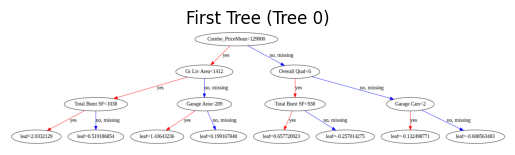

In [12]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(xgb80_20, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()



In [13]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# export first tree for a better visualization
# dot = to_graphviz(xgb80_20, num_trees=0, rankdir='UT')

# save as pdf
# dot.render("xgb80_20_tree0", format="pdf")   # or format="svg"

'DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

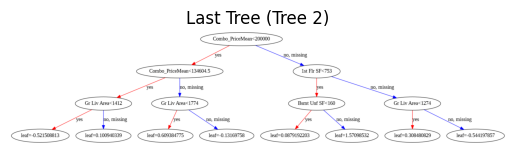

In [14]:
# last tree = index num_estimators - 1
last_tree_idx = xgb80_20.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(xgb80_20, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [15]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# export first tree for a better visualization
# dot = to_graphviz(xgb80_20, num_trees=last_tree_idx, rankdir='UT')

# save as pdf
# dot.render("xgb80_20_lasttree", format="pdf")   # or format="svg"

'DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'

10 90 train test split without stratification and tree plot + eval

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
xgb90_10 = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='multi:softmax', num_class=5)

In [18]:
xgb90_10.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=5, ...)

In [19]:
y_pred_90_10 = xgb90_10.predict(X_test)
y_pred_proba_90_10 = xgb90_10.predict_proba(X_test)

In [20]:
# accuracy
acc = accuracy_score(y_test, y_pred_90_10)
print(f'Accuracy: {acc:.4f}')

# classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_90_10))

# confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_90_10))


Accuracy: 0.6962

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        54
           1       0.58      0.58      0.58        66
           2       0.54      0.52      0.53        54
           3       0.74      0.70      0.72        64
           4       0.92      0.84      0.88        55

    accuracy                           0.70       293
   macro avg       0.70      0.70      0.70       293
weighted avg       0.70      0.70      0.70       293


Confusion Matrix:
 [[47  7  0  0  0]
 [16 38 10  2  0]
 [ 2 18 28  6  0]
 [ 0  2 13 45  4]
 [ 0  0  1  8 46]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

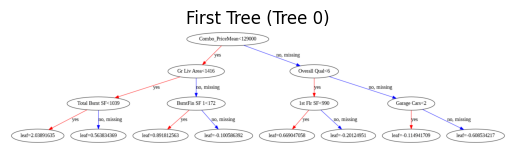

In [21]:
'''Plot first and last tree'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(xgb90_10, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()

In [22]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

dot = to_graphviz(xgb90_10, num_trees=0, rankdir='UT')

dot.render("xgb90_10_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'xgb90_10_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

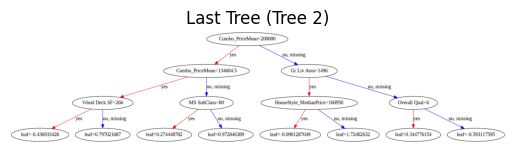

In [23]:
last_tree_idx = xgb90_10.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(xgb90_10, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [24]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
dot = to_graphviz(xgb90_10, num_trees=last_tree_idx, rankdir='UT')

dot.render("xgb90_10_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'xgb90_10_lasttree.pdf'

Now using stratified k-fold cv

First, 20 80 split

In [25]:
'''Split is done to obtain the test set that the model will NOT "see" during the k fold cv'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# used to store accuracies across folds (accuracy = chosen metric)
accuracy_scores_80_20 = []

In [35]:
'''
X_tr = X_train in the k fold cv i.e. a portion of the portion of X_train obtained earlier
X_val = X_test in the k fold cv i.e. the remaining portion of X_train

analogue for y_tr and y_val
'''

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=1, objective='multi:softmax', num_class=5)
    xgb.fit(X_tr, y_tr)

    predictions = xgb.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)

    accuracy_scores_80_20.append(accuracy)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
print(f"\nMean CV Accuracy: {np.mean(accuracy_scores_80_20):.4f}")

Fold 1 Accuracy: 0.7100
Fold 2 Accuracy: 0.6538
Fold 3 Accuracy: 0.7051
Fold 4 Accuracy: 0.7222
Fold 5 Accuracy: 0.7244

Mean CV Accuracy: 0.6967


In [36]:
best_xgb = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=1, objective='multi:softmax', num_class=5)
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_class=5, ...)

In [37]:
y_pred = best_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [38]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Test Accuracy: 0.7270

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       120
           1       0.57      0.61      0.59       121
           2       0.60      0.62      0.61       114
           3       0.77      0.72      0.74       120
           4       0.91      0.91      0.91       111

    accuracy                           0.73       586
   macro avg       0.73      0.73      0.73       586
weighted avg       0.73      0.73      0.73       586


Confusion Matrix:
 [[ 94  24   2   0   0]
 [ 20  74  22   5   0]
 [  1  29  71  13   0]
 [  0   2  22  86  10]
 [  0   0   2   8 101]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

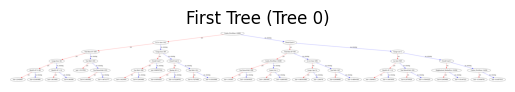

In [40]:
'''Plot trees'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(best_xgb, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()


In [ ]:
'''Export to pdf'''
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# dot = to_graphviz(best_xgb, num_trees=0, rankdir='UT')

# dot.render("best_xgb_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'best_xgb_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

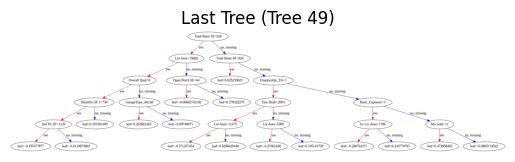

In [ ]:
last_tree_idx = best_xgb.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(best_xgb, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [ ]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# dot = to_graphviz(best_xgb, num_trees=last_tree_idx, rankdir='UT')

# dot.render("best_xgb_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'best_xgb_lasttree.pdf'

Now 10 90 split + stratified k fold cv

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [42]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# used to store accuracies across folds (accuracy = chosen metric)
accuracy_scores_90_10 = []

In [43]:
'''
X_tr = X_train in the k fold cv i.e. a portion of the portion of X_train obtained earlier
X_val = X_test in the k fold cv i.e. the remaining portion of X_train

analogue for y_tr and y_val
'''

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb2 = XGBClassifier(n_estimators=65, max_depth=6, learning_rate=1.45, objective='multi:softmax', num_class=5)
    xgb2.fit(X_tr, y_tr)

    predictions = xgb2.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)

    accuracy_scores_90_10.append(accuracy)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
print(f"\nMean CV Accuracy: {np.mean(accuracy_scores_90_10):.4f}")

Fold 1 Accuracy: 0.7424
Fold 2 Accuracy: 0.7273
Fold 3 Accuracy: 0.6932
Fold 4 Accuracy: 0.7083
Fold 5 Accuracy: 0.7148
Fold 6 Accuracy: 0.7072
Fold 7 Accuracy: 0.7529
Fold 8 Accuracy: 0.7262
Fold 9 Accuracy: 0.6882
Fold 10 Accuracy: 0.6996

Mean CV Accuracy: 0.7160


In [44]:
best_xgb2 = XGBClassifier(n_estimators=65, max_depth=6, learning_rate=1.45, objective='multi:softmax', num_class=5)
best_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.45, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=65,
              n_jobs=None, num_class=5, ...)

In [45]:
y_pred = best_xgb2.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [46]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Test Accuracy: 0.7474

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.81      0.77        54
           1       0.69      0.56      0.62        66
           2       0.61      0.70      0.66        54
           3       0.82      0.78      0.80        64
           4       0.91      0.91      0.91        55

    accuracy                           0.75       293
   macro avg       0.75      0.75      0.75       293
weighted avg       0.75      0.75      0.75       293


Confusion Matrix:
 [[44  8  2  0  0]
 [16 37 12  1  0]
 [ 1  9 38  6  0]
 [ 0  0  9 50  5]
 [ 0  0  1  4 50]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

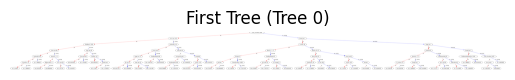

In [ ]:
'''Plot trees'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(best_xgb2, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()


In [ ]:
'''Export to pdf'''
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# dot = to_graphviz(best_xgb2, num_trees=0, rankdir='UT')

# dot.render("best_xgb2_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'best_xgb2_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

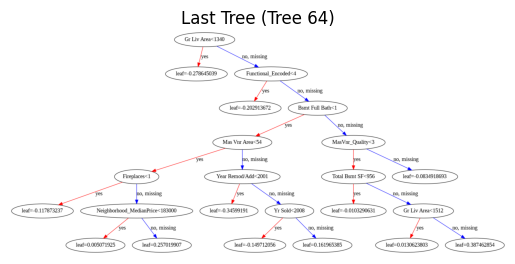

In [ ]:
last_tree_idx = best_xgb2.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(best_xgb2, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [ ]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# dot = to_graphviz(best_xgb2, num_trees=last_tree_idx, rankdir='UT')

# dot.render("best_xgb2_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'best_xgb2_lasttree.pdf'

Hyperparamater tuning using 90 10 split, as it gives a slithly better accuracy

First, GridSearch




In [48]:
parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 0],
    'learning_rate': [00.5, 0.1, 0.2, 0.5],
    'subsample': [0.8, 1.0], # fraction of the training samples (rows) used to grow each tree
    'colsample_bytree': [0.8, 1.0] # fraction of features (columns) used when building each tree
}


In [49]:
xgb = XGBClassifier(objective='multi:softmax', num_class=5)

grid = GridSearchCV(xgb, parameters, cv=5, scoring='accuracy')


In [50]:
'''DO NOT RUN TAKES TOO LONG'''
# grid.fit(X_train, y_train)

KeyboardInterrupt: 

Random Search Tuning

In [60]:
param_dist = {
    'max_depth': randint(3, 16),          # integer between 3 and 15
    'learning_rate': uniform(0.01, 0.49),  # float between 0.01 and 0.50
    'n_estimators': randint(50, 301),     # integer between 50 and 300
    'subsample': uniform(0.6, 0.4),       # float between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4)
}

In [61]:
xgb = XGBClassifier(objective='multi:softmax', num_class=5)
rand = RandomizedSearchCV(xgb, param_dist, cv=5, scoring='accuracy', n_iter=10)

In [62]:
search = rand.fit(X_train, y_train)
search.best_params_

{'colsample_bytree': np.float64(0.8667393192505074),
 'learning_rate': np.float64(0.24320261650839375),
 'max_depth': 3,
 'n_estimators': 298,
 'subsample': np.float64(0.7078011379258067)}

Use the Hyperparams found to train the best model

In [63]:
xgb = XGBClassifier(n_estimators=298, max_depth=3, subsample=0.7078011379258067, colsample_bytree=0.8667393192505074, learning_rate=0.24320261650839375, objective='multi:softmax', num_class=5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8667393192505074, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.24320261650839375,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=298, n_jobs=None, num_class=5, ...)

In [64]:
y_pred = xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [65]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Test Accuracy: 0.7679

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        54
           1       0.68      0.65      0.67        66
           2       0.65      0.67      0.66        54
           3       0.81      0.78      0.79        64
           4       0.88      0.91      0.89        55

    accuracy                           0.77       293
   macro avg       0.77      0.77      0.77       293
weighted avg       0.77      0.77      0.77       293


Confusion Matrix:
 [[46  7  1  0  0]
 [10 43 11  2  0]
 [ 0 13 36  5  0]
 [ 0  0  7 50  7]
 [ 0  0  0  5 50]]


Bayesian Optimization

In [70]:
'''Function to optimize i.e. fit method using given parameters'''
def black_box_function(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    xgb = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softmax',
        num_class=5
    )
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

In [71]:
'''Set the range for each hyperparameter'''
bounds = {
    'n_estimators': (50, 301),
    'max_depth': (3, 16),
    'learning_rate': (0.01, 0.50),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=bounds,
    random_state=42
)


In [72]:
optimizer.maximize(init_points=5, n_iter=50)

'''
x = Hyperparameters
f(x) = model’s performance metric, as returned by your evaluation function
      (for example: accuracy, F1, cross-validated score, etc.)
'''
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))


|   iter    |  target   | n_esti... | max_depth | learni... | subsample | colsam... |
-------------------------------------------------------------------------------------
| 1         | 0.7679180 | 144.00956 | 15.359285 | 0.3686770 | 0.8394633 | 0.6624074 |
| 2         | 0.7406143 | 89.154624 | 3.7550869 | 0.4344263 | 0.8404460 | 0.8832290 |
| 3         | 0.7645051 | 55.166708 | 15.608828 | 0.4178968 | 0.6849356 | 0.6727299 |
| 4         | 0.7440273 | 96.034531 | 6.9551491 | 0.2671306 | 0.7727780 | 0.7164916 |
| 5         | 0.7576791 | 203.57507 | 4.8134201 | 0.1531508 | 0.7465447 | 0.7824279 |
| 6         | 0.7713310 | 163.50195 | 12.852155 | 0.0698764 | 0.6195628 | 0.6104416 |
| 7         | 0.7372013 | 300.93955 | 15.353244 | 0.4034829 | 0.6314253 | 0.8944521 |
| 8         | 0.7610921 | 163.27499 | 13.936091 | 0.2560935 | 0.7464186 | 0.7844712 |
| 9         | 0.7679180 | 163.50060 | 11.187377 | 0.0295067 | 0.6       | 0.6       |
| 10        | 0.7440273 | 165.78875 | 12.358491 | 0.01

Use the Hyperparameters found to build another xgboost

In [74]:
xgb = XGBClassifier(n_estimators=274, max_depth=7, learning_rate=0.14222631089463744, subsample=0.8848721648492224, colsample_bytree=0.7160098522737178, objective='multi:softmax', num_class=5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7160098522737178, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14222631089463744,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=274, n_jobs=None, num_class=5, ...)

In [75]:
y_pred = xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [76]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Test Accuracy: 0.7782

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84        54
           1       0.74      0.68      0.71        66
           2       0.63      0.72      0.67        54
           3       0.79      0.78      0.79        64
           4       0.92      0.87      0.90        55

    accuracy                           0.78       293
   macro avg       0.78      0.78      0.78       293
weighted avg       0.78      0.78      0.78       293


Confusion Matrix:
 [[46  6  2  0  0]
 [ 9 45 10  2  0]
 [ 0 10 39  5  0]
 [ 0  0 10 50  4]
 [ 0  0  1  6 48]]
